# SYDE 552 Assignment 3: Hippocampal Models
### Due Monday, March, Anywhere on Earth 
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with associative memories. To do so, we'll be using pytorch to implement different associative memory models.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Hippocampus

**1.a) [2 marks]** The hippocampus is implicated in spatial navigation and episodic memory.  How do we know this?  What are some of the neuroscience results that revealed these facilities of the hippocampus?  (see Kandel *et al.* Ch. 65)

#### Your answer here

**1.b) [2 marks]** The Gluck and Meyers model of hippocampus is a simple, effective model of hippocampus, and how representations may be constructed for the slow transfer to the neocortex.  However, it still has its limitations.  Explain some (two or more) of the limitations of the Gluck and Meyers model.  (The Gluck and Meyers Ch.6 reading will be useful in answering this question.) 

#### Your answer here

**1.c) [2 mark]** Unsupervised pre-training is integral to the Gluck and Meyers model of Hippocampus, and unsupervised pre-training has been shown to accelerate reinforcement learning in rats navigating mazes.  However, unsupervised pre-training is not common in deep learning techniques.  Describe why that may be.  (See [$\S 15.1$ of Goodfellow *et al.*](https://www.deeplearningbook.org/contents/representation.html))

#### Your answer here

# 2. Hopfield Networks

## Preliminaries

Although you should have installed them for prior assignments, we will require the pytorch and keras. Let's install those now/

```pip install torch keras```

Next, we will download the MNIST dataset.  We will do this through the Keras library instead of torchvision. 

In [3]:
import tensorflow as tf
from tensorflow.compiler.tf2xla.python.xla import dynamic_update_slice
from keras.src.backend.common import KerasVariable
import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

As before, we will examine some of the images to make sure we got them right.

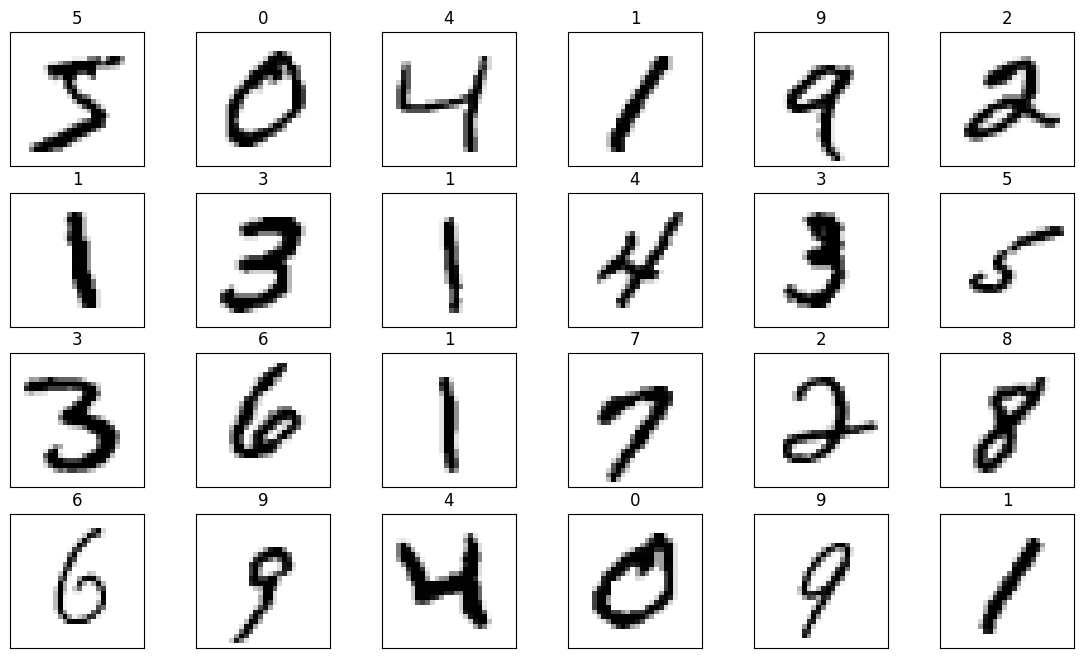

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape((28,28)), vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

Normally, the MNIST dataset has images represented by values in the range $[0,255]$. However, since we are dealing with Hopfield networks, we are going to binarize the data.

In [5]:
def binarize(xs):
    '''
    xs : a num_samples by num_features array of images.
    '''
    binary = (xs / 255) > 0.5
    integer = 2 * binary - 1
    return integer

binary_imgs = binarize(x_train)


Further, to make things easy on our network, we are only going to look at images of the digits 0, 1, and 2

In [6]:
binary_imgs = binary_imgs[y_train < 3,:]

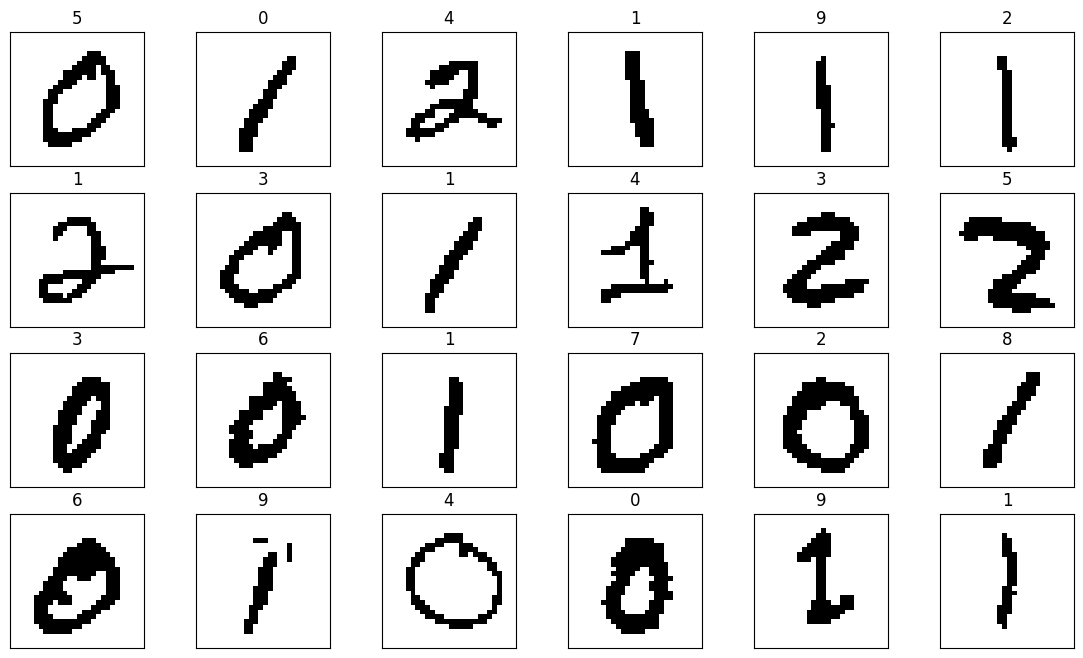

In [7]:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

We will also need to reshape the data into a vector representation, and then covert it to a pytorch tensor

In [8]:
import torch
binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)


**2.a) [2 Marks]**  Implement the Hopfield Network using Hopfield's learning rule.

We will first implement the Hopfield network using the outer product formulation for the weight matrix.  Given a set of patterns $\mathbf{x}_{i}$ , by first computing the matrix

$$D = \frac{1}{N}\sum_{i}^{N} (\mathbf{x}_{i}-\theta)(\mathbf{x}_{i}-\theta)^T$$

where $\theta = \frac{1}{ND}\sum_{i}^{N}\sum_{j}^{D} x_{i,j}$ , i.e., the average value of all elements in the training data.

Next we remove the diagonal element of the matrix, making the weight matrix:

$$
W = D - \mathrm{diag}(D),
$$

where $\mathrm{diag}(D)$ is the diagonal of the $D$ matrix.  Note that when implementing this in numpy or pytorch we must apply the ```diag``` function twice, i.e.:

```
W = D - torch.diag(torch.diag(D))

```

Here is some code to implement the learning rule:

In [9]:
import torch
def outer_product_hopfield_matrix(training_patterns):
    '''
    train_hopfield_matrix - produces a matrix for a (non-Modern) Hopfield network using the outer product rule.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
    
        A Tensor of shape (num_patterns, num_features) that will be used to construct the weight matrix.
        
    Returns:
    --------
    
    W : torch.Tensor
    
        A (num_features, num_features) Tensor that stores the papers encoded in the network.
    '''
    
    theta = torch.sum(training_patterns) / (training_patterns.shape[0] * training_patterns.shape[1])
    D = torch.einsum('nd,ne->de', training_patterns - theta, training_patterns - theta) / float(training_patterns.shape[0])
    W = (D - torch.diag(torch.diag(D))) 
    return W
def evaluate_hopfield_network(W, input_pattern, training_patterns=None, num_iters = 5, threshold=0):
    '''
    Evaluates a Hopfield network with weight matrix W on a number of test patterns.  Also computed the similarity 
    '''
    
    assert input_pattern.shape[0] == 1, f'''This function assumes you are cleaning up one pattern at a time. 
                                            Expected the input to be shape (1,{input_pattern.shape[1]}), 
                                            got {input_pattern.shape}'''
    
    input_pattern = input_pattern.squeeze(0)

    s = input_pattern.t()

    similarities = None
    if training_patterns is not None:
        similarities = torch.zeros((num_iters, training_patterns.shape[0]))
    ### end if
    
    for i in range(num_iters):
        s = torch.sign(W @ s - threshold)
        if training_patterns is not None:
            similarities[i,:] = torch.einsum('d,nd->n',s,training_patterns)
        ### end if
    ### end for
    return s, similarities

We want you to do the following things:

1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.
2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.
3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.
4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **training** images and compute the training error as the probability of noise increases.

In [10]:
## 2.a.1 - Compute network capacity.
import numpy as np

d = 784 #number of neurons
C =  d/(2*np.log2(d))# your code here
print(C)

40.770861144595855


C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\2239996857.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  reconstructed_image = W @ binary_img_tensor[i].T


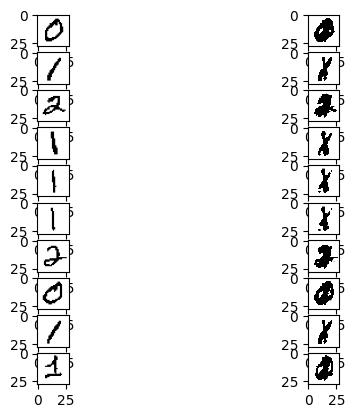

In [11]:
# 2.a.2 - plot original and reconstructed images.
plt.figure()
# create weight matrix, W
W = outer_product_hopfield_matrix(binary_img_tensor[:10,:])

for i in range(10):
    # reconstruct training image, i.
    reconstructed_image = W @ binary_img_tensor[i].T

    plt.subplot(10,2,1+2*i)
    # plot original image 
    # [your code here]
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    
    plt.subplot(10,2,1+2*i+1)
    # plot reconstructed image.
    # [your code here]
    plt.imshow(reconstructed_image.reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    #plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')


INSTRUCTIONS AGAIN
1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.
2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.
3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.
4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **training** images and compute the training error as the probability of noise increases.

torch.Size([10, 784])


C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1419407449.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_error = torch.tensor(training_error)  # Convert to tensor
C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1419407449.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_error = torch.tensor(test_error)  # Convert to tensor


torch.Size([10, 784])
torch.Size([10, 784])
torch.Size([10, 784])
torch.Size([10, 784])


Text(0, 0.5, 'mse')

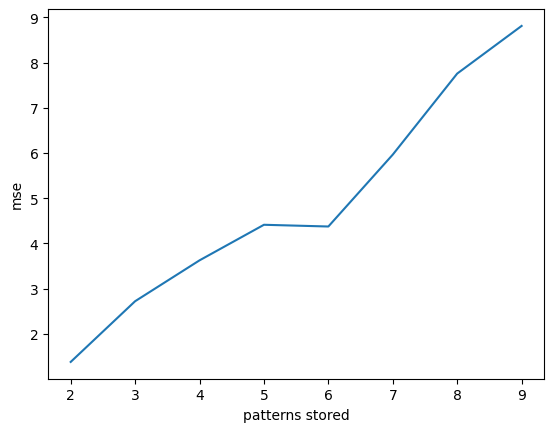

In [50]:
# 2.a.3 - Plot training and test error
import random

def mse(true_vals, pred_val):
    n = len(true_vals)
    MSE = 0
    for i in range(n):
        MSE += (true_vals[i] - pred_val[i])**2
    MSE = MSE/n
    return MSE ### your code here

def test_network(training_patterns, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros((len(range(2,C),)))
    test_error = torch.zeros((len(range(2,C),)))
    
    for pattern_idx, num_patterns in enumerate(range(2,C)):
        # train network
        W = outer_product_hopfield_matrix(binary_img_tensor[:num_patterns,:])
        for test_idx in range(num_patterns):
            # for each image in the training set, compute the mse
            reconstructed_pattern, _ = evaluate_hopfield_network(W, training_patterns[test_idx].unsqueeze(0), training_patterns)
            training_error[pattern_idx] += (mse(training_patterns[test_idx],reconstructed_pattern ))

            # for each image in the testing set, compute the mse
            reconstructed_pattern, _ = evaluate_hopfield_network(W, test_patterns[test_idx].unsqueeze(0), training_patterns)
            test_error[pattern_idx] += (mse(training_patterns[test_idx],reconstructed_pattern ))
        ### end for
    ### end for
    training_error = torch.tensor(training_error)  # Convert to tensor
    test_error = torch.tensor(test_error)  # Convert to tensor

    return training_error, test_error

C = 10
num_patterns = 5

average_results = []

for id in range(num_patterns):
    indices = torch.randperm(len(binary_img_tensor))[:C]
    train_patterns = binary_img_tensor[indices]

    indices = torch.randperm(len(binary_img_tensor))[:C]
    test_patterns = binary_img_tensor[indices]
    training_error, test_error = test_network(train_patterns, test_patterns, C)
    average_results.append(training_error)
    average_results.append(test_error)

average_results = sum(average_results)/len(average_results) # your code here.

plt.figure()
plt.plot(range(2,C), average_results )
plt.xlabel('patterns stored')
plt.ylabel('mse')

C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1419407449.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_error = torch.tensor(training_error)  # Convert to tensor
C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1419407449.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_error = torch.tensor(test_error)  # Convert to tensor


Text(0, 0.5, 'mse')

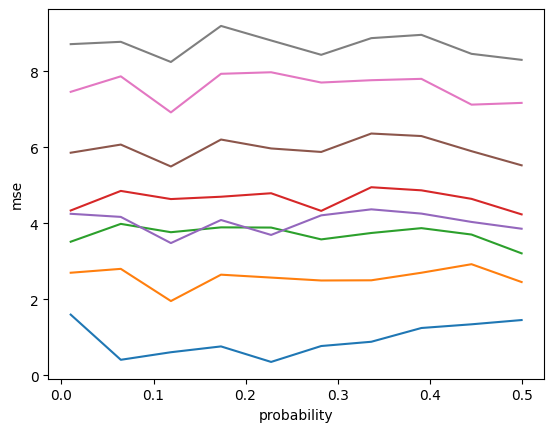

In [70]:
# 2.a.4 - Test salt-and-pepper noise.
def add_noise(training_image, amount):
    
    y, x = training_image.shape
    #print(training_image.shape)
    noisy_image = training_image.clone()
    
    num_salt = int(torch.ceil(amount * training_image.numel() * 0.5).item())
    num_pepper = int(torch.ceil(amount * training_image.numel() * 0.5).item())

    for _ in range(num_salt):
        noisy_image[random.randint(0, y-1), random.randint(0, x-1)] = 255
    for _ in range(num_pepper):
        noisy_image[random.randint(0, y-1), random.randint(0, x-1)] = 0
    #print(noisy_image.shape)
    return noisy_image
C = 10
num_steps = 10 ### Pick a value
prob_flip = torch.linspace(0.01,0.5,num_steps)

training_data = binary_img_tensor# Your code here
testing_data = []
mses = []
    
W = outer_product_hopfield_matrix(binary_img_tensor[:C,:])# Your code here

for p_idx, p in enumerate(prob_flip):
    ## Your code here
    indices = torch.randperm(len(binary_img_tensor))[:C]
    train_patterns = binary_img_tensor[indices]

    indices = torch.randperm(len(binary_img_tensor))[:C]
    testing_data = binary_img_tensor[indices]

    testing_data = add_noise(testing_data, p)
    #print(testing_data.shape)
    training_error, test_error = test_network(train_patterns, testing_data, C) 
    mses.append(training_error)

    pass

plt.figure()
plt.plot(prob_flip.numpy(), mses)
plt.xlabel('probability')
plt.ylabel('mse')

**2.b) [2 Mark]** Train Hopfield network using the pseudo-inverse and repeat the tasks 2.a) 2-4, however, for this example, ensure the threshold value is 0.  Even though the pseudo-inverse has a greater capacity thant he hopfield network, we will still test up to the theoretical capcity of the Hopfield learning rule.

In [80]:
def pseudo_inv(X, lamb=0.01):
    '''
    pseudo_inv - Implements the pseudoinverse from the previous assignment.
    
    Parameters:
    -----------
    
    X : torch.Tensor
        A (num_patterns, num_features) Tensor holding the training data.
        
    lamb : float
        The regularization term for the pseudoinverse
        
    
    Returns:
    --------
    
    The pseudoinverse of X
    '''
    return torch.inverse(X.T@X + lamb * torch.eye(X.shape[1]).float()) @ X.T

def pseudoinverse_hopfield_matrix(training_patterns, lamb = 0.01):
    '''
    pseudoinverse_hopfield_matrix - Uses the regularized pseudoinverse to construct a weight matrix for
        a non-modern Hopfield network.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
        
        The (num_patterns, num_features) Tensor containing the training data.
        
    lamb : float
    
        The regularization term for the pseudo-inverse. 
        
    Returns:
    --------
    
        The weight matrix compatible with the evaluate_hopfield_network function 
    '''
    W = pseudo_inv(training_patterns, lamb=lamb) @ training_patterns
    return W / training_patterns.shape[0]



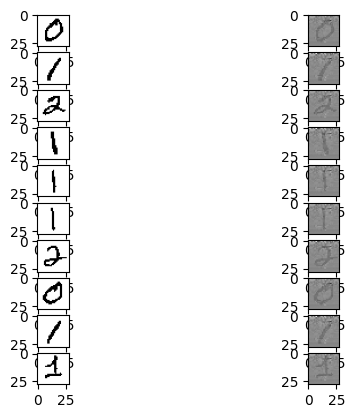

In [81]:
# 2.b.2 - plot original and reconstructed images.
plt.figure()
# create weight matrix, W
binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)

W = pseudoinverse_hopfield_matrix(binary_img_tensor[:10,:])

for i in range(10):
    # reconstruct training image, i.
    reconstructed_image = W @ binary_img_tensor[i].T

    plt.subplot(10,2,1+2*i)
    # plot original image 
    # [your code here]
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    
    plt.subplot(10,2,1+2*i+1)
    # plot reconstructed image.
    # [your code here]
    plt.imshow(reconstructed_image.reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    #plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1365194019.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_error = torch.tensor(training_error)  # Convert to tensor
C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1365194019.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_error = torch.tensor(test_error)  # Convert to tensor


Text(0, 0.5, 'mse')

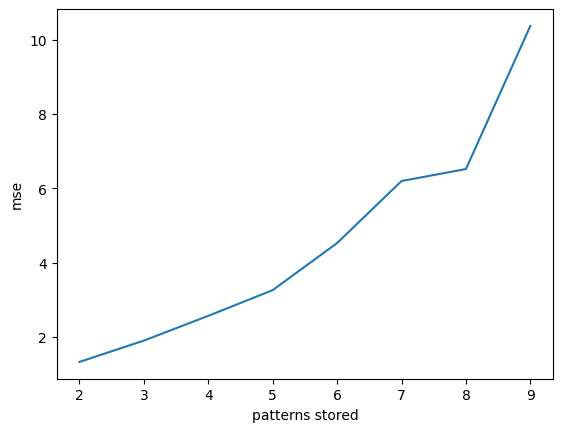

In [82]:
# 2.b.3 - Plot training and test error
import random

def mse(true_vals, pred_val):
    n = len(true_vals)
    MSE = 0
    for i in range(n):
        MSE += (true_vals[i] - pred_val[i])**2
    MSE = MSE/n
    return MSE ### your code here

def test_network(training_patterns, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros((len(range(2,C),)))
    test_error = torch.zeros((len(range(2,C),)))
    
    for pattern_idx, num_patterns in enumerate(range(2,C)):
        # train network
        W = pseudoinverse_hopfield_matrix(binary_img_tensor[:num_patterns,:])
        for test_idx in range(num_patterns):
            # for each image in the training set, compute the mse
            reconstructed_pattern, _ = evaluate_hopfield_network(W, training_patterns[test_idx].unsqueeze(0), training_patterns)
            training_error[pattern_idx] += (mse(training_patterns[test_idx],reconstructed_pattern ))

            # for each image in the testing set, compute the mse
            reconstructed_pattern, _ = evaluate_hopfield_network(W, test_patterns[test_idx].unsqueeze(0), training_patterns)
            test_error[pattern_idx] += (mse(training_patterns[test_idx],reconstructed_pattern ))
        ### end for
    ### end for
    training_error = torch.tensor(training_error)  # Convert to tensor
    test_error = torch.tensor(test_error)  # Convert to tensor

    return training_error, test_error

C = 10
num_patterns = 5

average_results = []

for id in range(num_patterns):
    indices = torch.randperm(len(binary_img_tensor))[:C]
    train_patterns = binary_img_tensor[indices]

    indices = torch.randperm(len(binary_img_tensor))[:C]
    test_patterns = binary_img_tensor[indices]
    training_error, test_error = test_network(train_patterns, test_patterns, C)
    average_results.append(training_error)
    average_results.append(test_error)

average_results = sum(average_results)/len(average_results) # your code here.

plt.figure()
plt.plot(range(2,C), average_results )
plt.xlabel('patterns stored')
plt.ylabel('mse')

C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1365194019.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_error = torch.tensor(training_error)  # Convert to tensor
C:\Users\Abby\AppData\Local\Temp\ipykernel_33712\1365194019.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_error = torch.tensor(test_error)  # Convert to tensor


Text(0, 0.5, 'mse')

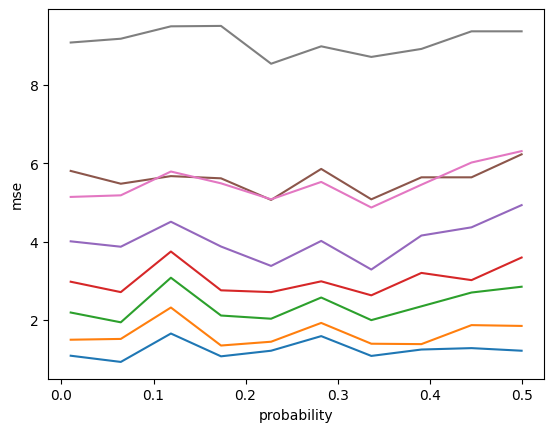

In [83]:
# 2.b.4 - Test salt-and-pepper noise.
def add_noise(training_image, amount):
    
    y, x = training_image.shape
    #print(training_image.shape)
    noisy_image = training_image.clone()
    
    num_salt = int(torch.ceil(amount * training_image.numel() * 0.5).item())
    num_pepper = int(torch.ceil(amount * training_image.numel() * 0.5).item())

    for _ in range(num_salt):
        noisy_image[random.randint(0, y-1), random.randint(0, x-1)] = 255
    for _ in range(num_pepper):
        noisy_image[random.randint(0, y-1), random.randint(0, x-1)] = 0
    #print(noisy_image.shape)
    return noisy_image
C = 10
num_steps = 10 ### Pick a value
prob_flip = torch.linspace(0.01,0.5,num_steps)

training_data = binary_img_tensor# Your code here
testing_data = []
mses = []
    
W = pseudoinverse_hopfield_matrix(binary_img_tensor[:C,:])# Your code here

for p_idx, p in enumerate(prob_flip):
    ## Your code here
    indices = torch.randperm(len(binary_img_tensor))[:C]
    train_patterns = binary_img_tensor[indices]

    indices = torch.randperm(len(binary_img_tensor))[:C]
    testing_data = binary_img_tensor[indices]

    testing_data = add_noise(testing_data, p)
    #print(testing_data.shape)
    training_error, test_error = test_network(train_patterns, testing_data, C) 
    mses.append(training_error)

    pass

plt.figure()
plt.plot(prob_flip.numpy(), mses)
plt.xlabel('probability')
plt.ylabel('mse')

**2.c) [1 Mark]** Show how the network behaves when an entire region of the image is corrupted. 

For your best performing network, take three test images and set half of the inputs to be equal to zero.  
Plot the original images, the corrupted images, and the reconstructed images, side-by-side.

torch.Size([28, 28])


TypeError: ceil(): argument 'input' (position 1) must be Tensor, not float

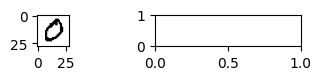

In [117]:
# Your code here
# 2.b.4 - Test salt-and-pepper noise.
def add_noise(training_image, amount):
    
    y, x = training_image.shape
    print(training_image.shape)
    noisy_image = training_image.clone()
    
    num_salt = int(torch.ceil(amount * training_image.numel() * 0.5).item())
    num_pepper = int(torch.ceil(amount * training_image.numel() * 0.5).item())

    for _ in range(num_salt):
        noisy_image[random.randint(0, y-1), random.randint(0, x-1)] = 255
    for _ in range(num_pepper):
        noisy_image[random.randint(0, y-1), random.randint(0, x-1)] = 0
    #print(noisy_image.shape)
    return noisy_image
C = 3
num_steps = 10 ### Pick a value
prob_flip = 1

training_data = binary_img_tensor# Your code here
testing_data = []
mses = []
    
W = pseudoinverse_hopfield_matrix(binary_img_tensor[:C,:])# Your code here

for i in range(3):
    # reconstruct training image, i.
    reconstructed_image = W @ training_data[i].T

    plt.subplot(10,3,1+3*i)
    # plot original image 
    # [your code here]
    plt.imshow(training_data[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

    plt.subplot(10,3,1+3*i+1)
    # plot reconstructed image.
    # [your code here]
    plt.imshow(add_noise(binary_img_tensor[i].reshape((28,28)), 1), vmin=-1, vmax=1, cmap='gray_r')
    
    plt.subplot(10,3,1+3*i+2)
    # plot reconstructed image.
    # [your code here]
    plt.imshow(reconstructed_image.reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    #plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

# 3. Autoencoders

Now we are going to train an autoencoder to perform the same associative task that we explored above.  We are going to define our Autoencoder using sigmoid neurons, which shouldn't be too terrible, since it is a relatively shallow network, but one is not obligated to use those. 

Because we are going to use a sigmoidal output function, so we should be concerned with values in the range $[0,1]$, instead of $\{-1,1\}$.  Training will be done using the original MNIST images, **not** the binary images.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.from_numpy(x_train.reshape((-1,28*28) / 255))
x_test_tensor = torch.from_numpy(x_test.reshape((-1,28*28) / 255))

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Sigmoid activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, num_hidden),
            torch.nn.Sigmoid(),            
        )
         
        # Building an linear decoder with Linear
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(num_hidden, num_inputs),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        epoch_loss = []
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data 
            loss = F.mse_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            epoch_loss.append(loss.detach().numpy())
            

    # update the list of training accuracy values
    training_loss.append(np.mean(epoch_loss)) # store the loss for later.
    print('Iteration', len(training_loss), 'Training loss:', training_loss[-1])
    
    correct = 0
    network.eval()
    test_set_loss = []
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        loss = F.mse_loss(output, target)
        test_set_loss.append(loss.detach().numpy())
        
        
    # update the list of testing accuracy values
    testing_loss.append(np.mean(test_set_loss))
    print('Iteration', len(testing_loss), 'Testing accuracy:', testing_loss[-1])

**3.1 [2 Marks]** For the autoencoder we will do the following:

1. Train the network and plot the testing and training losses(repeated trials) for 5 different different values of the hidden layer size.  **Ensure the number of hidden layers is always less than the number of input features**.  Select a good number of training iterations (i.e., not overfitting) and a good number of hidden neurons
2. Plot 10 input and reconstructed images from the training set and 10 from the testing set.  How do these compare to the reconstructions of from the Hopfield networks you constructed above?
3. With your trained network, compare the loss on inputs corrupted salt and pepper noise.  Sweep through a range of number of pixels corrupted from 0 to 75\%.  Because the image data is back in the range $[0,1]$, this time corrupt the image by setting pixels to equal 0 or 1 with 50\% probability.

In [ ]:
network = ## Create the autoencoder here

training_loss = []
testing_loss = []

# We're all hip, fashionable people here, let's use the Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)


**3.2 [1 Mark]** Described what you've observed about the results of the autoencoder, compared to the Hopfield networks.

#### Your answer here

**3.3 [1 Marks]** Sensory Preconditioning - Now we are going to look at small datasets. We are going to use the sensory preconditioning protocol, discussed by Gluck and Meyers.

We will also need to construct a data set that performs the preconditioning.  We will break this down into three phases:

1. Do the sensory preconditioning.  Plot the training loss vs number of epochs, describe the resultant behaviour.

In [ ]:
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:
        
        # Output of Autoencoder
        reconstructed = model(inp)
    
        # Calculating the loss function
        loss = loss_function(reconstructed, out)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass 

In [ ]:
# Plot loss performance.
# Your code here

2. Train the conditioned response to one stimulus.  We will train this using simple linear regression where we map the the hidden state to the desired output.  You can reuse the linear regression code from above.

Lets call the features (columns) of the stimuli data as s1, s2, c1, and c2.

In [ ]:

conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
conditioning_outputs = torch.from_numpy(np.array([[0,0,0,0,1,1,1,1]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

def get_weights(features, values, lamb=0.01):
    pass # Your code here

def evaluate(weights, features):
    pass # your code here

W = get_weights(conditioning_features, conditioning_outputs)
conditioned_response = evaluate(W, conditioning_features[4:,:])

3. Report the strength of the conditioned response to the other stimulus.  Has the network transferred learning from one stimuls to the other?

In [ ]:
test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)

transferred_response = evaluate(W, testing_features)


4. Compare to the response of the system without either of the preconditioned inputs

In [ ]:
unconditioned_responses = evaluate(W, conditioning_features[:4,:])

5. Plot graphs showing the strength of the response to the conditioned stimuli, the pre-conditioned stimuli, and the unconditioned stimuli
(*i.e.*, s1 = 0, s2 = 0, and context in $\{(0,0),(0,1),(1,0),(1,1)\}$)

In [ ]:
response_mu = None # Your code here
response_std = None # your code here

ax.bar([1,2,3], response_mu, yerr=response_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3], labels=['s1+', 's2+', 's1-,s2-'])

**[BONUS]** [1 Mark] Repeat the sensory preconditioning, but use an conditioning stimulus that is not 100\% correlated with the unconditioned stimulus. That is: change phase 2 so that it is not possible to perfectly predict the output.